In [1]:
import cv2
import pandas as pd
import numpy as np
import aeon.io.api as aeon
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from matplotlib.cbook import boxplot_stats
from aeon.io import reader
from aeon.analysis.movies import gridframes
from aeon.analysis.utils import *
from aeon.schema.dataset import exp02
from aeon.io.video import frames, export


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Extract start end times for sessions
# get subject enter, exit times
root = "/ceph/aeon/aeon/data/raw/AEON3/rfid-test"
subject_visits = visits(aeon.load(root, exp02.ExperimentalMetadata.SubjectState, start=pd.Timestamp("2023-08-21 00:00:00"), end=pd.Timestamp("2023-08-23 00:00:00")))
# get maintenance, experiment times
env_states = aeon.load(root, exp02.ExperimentalMetadata.EnvironmentState,  start=pd.Timestamp("2023-08-21 00:00:00"), end=pd.Timestamp("2023-08-23 00:00:00"))
env_states = env_states[~env_states.index.duplicated(keep="first")]
# get env_states timestamps after largest enter and before smallest exit
maintenance_states = env_states[env_states["state"] == "Maintenance"]
experiment_states = env_states[env_states["state"] == "Experiment"]
start_times = experiment_states.index[experiment_states.index.get_indexer(subject_visits["enter"], method='bfill')]
end_times = maintenance_states.index[maintenance_states.index.get_indexer(subject_visits["exit"], method='ffill')]
print(start_times)
print(end_times)

DatetimeIndex(['2023-08-21 14:40:14.208000183',
               '2023-08-21 14:40:14.208000183',
               '2023-08-22 09:56:56.607999802',
               '2023-08-22 14:41:20.863999844',
                         '2023-08-22 15:27:31'],
              dtype='datetime64[ns]', name='time', freq=None)
DatetimeIndex(['2023-08-21 15:14:11.144000053',
               '2023-08-21 16:00:53.320000172',
               '2023-08-22 10:40:58.776000023',
               '2023-08-22 15:22:07.544000149',
               '2023-08-22 15:56:25.111999989'],
              dtype='datetime64[ns]', name='time', freq=None)


In [3]:
rfid_data = {
    "0821": { # BAA-1103352
        "root": "/ceph/aeon/aeon/data/raw/AEON3/rfid-test",
        "start": pd.Timestamp("2023-08-21 15:16:26.432000160"),
        "end": pd.Timestamp("2023-08-21 16:00:53.320000172"),
        "rfid_corridor": {
            "coords": [(176, 545), (196, 545), (176, 565), (196, 565)],
        },
        "rfid_patch2": {
            "coords": [(820, 737), (836, 727), (830, 753), (846, 743)],
        },
        "rfid_nestne": {
            "coords": [(1230, 579), (1250, 579), (1230, 599), (1250, 599)],
        },
        "rfid_nestnw": {
            "coords": [(1228, 467), (1248, 467), (1228, 487), (1248, 487)],
        },
        "rfid_water": {
            "coords": [(1293, 468), (1313, 468), (1293, 474), (1313, 474)],
        },  
    },
    "0822a": { # BAA-1103369	
        "root": "/ceph/aeon/aeon/data/raw/AEON3/rfid-test",
        "start": pd.Timestamp("2023-08-22 09:56:56.607999802"),
        "end": pd.Timestamp("2023-08-22 10:40:58.776000023"),
        "rfid_corridor": {
            "coords": [(176, 545), (196, 545), (176, 565), (196, 565)],
        },
        "rfid_patch2": {
            "coords": [(820, 737), (836, 727), (830, 753), (846, 743)],
        },
        "rfid_nestne": {
            "coords": [(1230, 579), (1250, 579), (1230, 599), (1250, 599)],
        },
        "rfid_nestnw": {
            "coords": [(1228, 467), (1248, 467), (1228, 487), (1248, 487)],
        },
        "rfid_water": {
            "coords": [(1293, 468), (1313, 468), (1293, 474), (1313, 474)],
        },  
    },
    "0822b": { # BAA-1103369	
        "root": "/ceph/aeon/aeon/data/raw/AEON3/rfid-test",
        "start": pd.Timestamp("2023-08-22 14:41:20.863999844"),
        "end": pd.Timestamp("2023-08-22 15:22:07.544000149"),
        "rfid_corridor": {
            "coords": [(176, 545), (196, 545), (176, 565), (196, 565)],
        },
        "rfid_patch2": {
            "coords": [(820, 737), (836, 727), (830, 753), (846, 743)],
        },
        "rfid_nestne": {
            "coords": [(1227, 623), (1245, 629), (1221, 642), (1239, 648)],
        },
        "rfid_nestnw": {
            "coords": [(1227, 451), (1247, 451), (1227, 471), (1247, 471)],
        },
        "rfid_water": {
            "coords": [(1293, 468), (1313, 468), (1293, 474), (1313, 474)],
        },  
    },
    "0822c": { # BAA-1103352
        "root": "/ceph/aeon/aeon/data/raw/AEON3/rfid-test",
        "start": pd.Timestamp("2023-08-22 15:27:31"),
        "end": pd.Timestamp("2023-08-22 15:56:25.111999989"),
        "rfid_corridor": {
            "coords": [(176, 545), (196, 545), (176, 565), (196, 565)],
        },
        "rfid_patch2": {
            "coords": [(820, 737), (836, 727), (830, 753), (846, 743)],
        },
        "rfid_nestne": {
            "coords": [(1227, 623), (1245, 629), (1221, 642), (1239, 648)],
        },
        "rfid_nestnw": {
            "coords": [(1227, 451), (1247, 451), (1227, 471), (1247, 471)],
        },
        "rfid_water": {
            "coords": [(1293, 468), (1313, 468), (1293, 474), (1313, 474)],
        }, 
    },
}

In [4]:
# helper functions

RFID_NAMES = ["RfidCorridor", "RfidNestNE", "RfidNestNW", "RfidPatch2", "RfidWater"]
RFID_FILE_PATTERNS = {"_".join(["rfid", rfid_name.lower().split("rfid")[1]]): f'{rfid_name}_32_*' for rfid_name in RFID_NAMES}


def calc_dist(data_diff, x_label="x", y_label="y"):
    return np.linalg.norm(data_diff[[x_label, y_label]], axis=1)


def calc_velocity(data, x_label="x", y_label="y"):
    return calc_dist(data[[x_label, y_label]].diff(), x_label, y_label) / (
        data.index.to_series().diff().dt.total_seconds()
    )


def populate_session_data(session: dict):
    session["pos"] = aeon.load(
        session["root"],
        exp02.CameraTop.Position,
        start=session["start"],
        end=session["end"],
    ).dropna()
    session["pos"]["velocity"] = calc_velocity(session["pos"])
    session["pos_enter"] = pd.DataFrame()

    # get all rfid keys
    rfid_keys = [key for key in session.keys() if key.startswith("rfid_")]
    for key in rfid_keys:
        # calculate midpoint and radius of rfid antenna
        session[key]["mid"] = (
            (session[key]["coords"][2][0] + session[key]["coords"][1][0]) / 2,
            (session[key]["coords"][2][1] + session[key]["coords"][1][1]) / 2,
        )
        session[key]["radius"] = np.sqrt(
            (session[key]["mid"][0] - session[key]["coords"][0][0]) ** 2
            + (session[key]["mid"][1] - session[key]["coords"][0][1]) ** 2
        )
        # get enter times of rfid antenna
        session[key]["enter"] = aeon.load(
            session["root"],
            reader.Harp(pattern=RFID_FILE_PATTERNS[key], columns=["Rfid"]),
            start=session["start"],
            end=session["end"],
        )
        # get enter positions 
        """ pos_enter = aeon.load(
            session["root"],
            exp02.CameraTop.Position,
            time=session[key]["enter"].index
        ).dropna()
        """
        pos_enter = session["pos"].iloc[session["pos"].index.get_indexer(session[key]["enter"].index, method='ffill')]
        pos_enter.drop_duplicates(inplace=True)
        # calculate pos distance from rfid antenna
        pos_enter["rfid_dist"] = calc_dist(
            pd.concat(
                [
                    pos_enter.x - session[key]["mid"][0],
                    pos_enter.y - session[key]["mid"][1],
                ],
                axis=1,
            )
        )
        # get pos velocity at enter time
        pos_enter["velocity"] = session["pos"].iloc[
            session["pos"].index.get_indexer(pos_enter.index, method='ffill')]["velocity"].values
        pos_enter["rfid_enter"] = key
        session["pos_enter"] = pd.concat([session["pos_enter"], pos_enter])
    
    session["pos_enter"] = session["pos_enter"].sort_index()

    # associate each position to the nearest RFID enter time
    session["pos"] = assign_nearest_rfid_time(session["pos"], session["pos_enter"]["rfid_enter"] , "rfid_enter_time")
    session["pos"]["dt_enter"] = (session["pos"].index.to_series() - session["pos"]["rfid_enter_time"]).dt.total_seconds()
    session["pos"]["rfid_dist"] = session["pos"].apply(lambda row: np.sqrt((row["x"] - session[row["rfid_enter"]]["mid"][0]) ** 2 + (row["y"] - session[row["rfid_enter"]]["mid"][1]) ** 2), axis=1)

    # compute threshold values (min, 50%, 75%, max) for each rfid
    session["distance_thresholds"] = session["pos_enter"].groupby("rfid_enter")["rfid_dist"].describe()[["min", "50%", "75%", "max"]]

    # get all positions within each threshold of each rfid
    pos_near_rfid = pd.DataFrame()
    for col in session["distance_thresholds"].columns:
        for key in rfid_keys:
            mask_rfid = (session["pos"]["rfid_enter"] == key)
            mask_threshold = (session["pos"]["rfid_dist"] <= session["distance_thresholds"].get(col).get(key))
            if mask_rfid.sum():
                pos_near_rfid = pd.concat([
                    pos_near_rfid, 
                    session["pos"][mask_rfid & mask_threshold].assign(threshold=col)
                ])
    session["pos_near_rfid"] = pos_near_rfid

    # Select 75% as distance threshold
    pos_near_rfid_q3 = pos_near_rfid[pos_near_rfid["threshold"] == "75%"].sort_index()
    pos_near_rfid_q3["consecutive"] = pos_near_rfid_q3.reset_index()["time"].diff().set_axis(pos_near_rfid_q3.index)
    pos_near_rfid_q3.loc[pos_near_rfid_q3["consecutive"] > pd.Timedelta("25ms"), "consecutive"] = pd.NaT
    session["pos_near_rfid_q3"] = pos_near_rfid_q3
    
    # Extract outliers (+/-1.5*IQR) based on dt_enter as false negatives
    fn = {
        key: boxplot_stats(pos_near_rfid_q3[pos_near_rfid_q3["rfid_enter"] == key]["dt_enter"])[0]["fliers"]
        for idx, key in enumerate(rfid_keys)
    }
    # map outliers to original data
    pos_near_rfid_q3_fn = pd.concat([pos_near_rfid_q3[(pos_near_rfid_q3["dt_enter"].isin(fn[key])) & (pos_near_rfid_q3["rfid_enter"] == key)] for key in rfid_keys]).sort_index()
    session["pos_near_rfid_q3_fn"] = pos_near_rfid_q3_fn
    
    # compute timedelta thresholds (q1-1.5*iqr, q3+1.5*iqr) for each rfid
    q1 = pos_near_rfid_q3.groupby("rfid_enter")["dt_enter"].quantile(0.25)
    q3 = pos_near_rfid_q3.groupby("rfid_enter")["dt_enter"].quantile(0.75)
    lower_bound = (q1 - (1.5 * (q3 - q1))).rename("lower_bound")
    upper_bound = (q3 + (1.5 * (q3 - q1))).rename("upper_bound")
    session["timedelta_thresholds"] = pd.concat([lower_bound, upper_bound], axis=1)

    # compute roi enter and exit times
    roi_enter = pos_near_rfid_q3[pos_near_rfid_q3["consecutive"].isna()]
    roi_enter_times = roi_enter.index.values
    # these are the actual exit times but rfid reads may happen just at the actual exit so we need the use the next enter time as boundary
    #na_idx = roi_enter.index[1:]
    #exit_idx = pos_near_rfid_q3.index.get_indexer(na_idx) - 1
    #roi_exit_times = pos_near_rfid_q3.iloc[exit_idx].index.values
    roi_enter_exit = pd.DataFrame(
        {"enter": roi_enter_times,
        "exit": np.hstack((roi_enter_times[1:], pos_near_rfid_q3.index[-1].to_numpy())), # next enter time as boundary for counting rfid_reads
        "rfid_enter": roi_enter["rfid_enter"].values
        })
    # count number of rfid reads, time spent in roi, and rfid reads per second
    roi_enter_exit["rfid_reads"] = roi_enter_exit.apply(lambda row: len(session["pos_enter"][row["enter"]:row["exit"]]), axis=1)
    # dt is the time spent in the roi, and uses the actual exit times
    roi_enter_exit["dt"] = roi_enter_exit.apply(lambda row: ((pos_near_rfid_q3[row["enter"]:row["exit"]].index[-2]) - row["enter"]).total_seconds() if len(pos_near_rfid_q3[row["enter"]:row["exit"]]) > 2 else pd.NaT, axis=1) # assume subject is in ROI for at least 2 frames
    roi_enter_exit["reads_per_sec"] = roi_enter_exit["rfid_reads"] / roi_enter_exit["dt"]
    roi_enter_exit.dropna(inplace=True) 
    # consider 0 reads as false negatives
    roi_enter_exit_fn = roi_enter_exit[roi_enter_exit["rfid_reads"] < 1].reset_index(drop=True)
    # get false negative "paths"
    roi_enter_exit_fn_paths = pd.concat(roi_enter_exit_fn.apply(lambda row: pos_near_rfid_q3.loc[row["enter"]:row["exit"]][:-1].assign(group=row.name), axis=1).tolist())
    session["roi_enter_exit"] = roi_enter_exit
    session["roi_enter_exit_fn"] = roi_enter_exit_fn
    session["roi_enter_exit_fn_paths"] = roi_enter_exit_fn_paths

    return session


def assign_nearest_rfid_time(pos, rfid_time, col_name):
    # associate each position to the nearest RFID time
    pos = pd.merge_asof(
        pos,
        rfid_time.reset_index().rename(columns={"time": col_name}),
        right_on=col_name,
        left_index=True,
        direction="nearest",
    )
    return pos


In [5]:
# plotting functions

def plot_pos_overlay(pos, img, title, rfid_coords=None, grouping_key="rfid_enter"):
    # plot position data overlayed on image, with optional rfid bounding boxes
    fig, ax = plt.subplots(figsize=(1440 / 96, 1080 / 96))
    im = ax.imshow(plt.imread(img), extent=[0, 1440, 1080, 0])
    sns.scatterplot(data=pos, x="x", y="y", alpha=0.8, s=8, hue=grouping_key, ax=ax)
    if rfid_coords:
        # plot rfid bounding boxes
        for rfid_coord in rfid_coords:
            rfid_coord = rfid_coord + [rfid_coord[0]]
            xs, ys = zip(*rfid_coord)
            ax.plot(xs, ys, c="black", alpha=0.5)
    #cbar = fig.colorbar(points)
    #cbar.set_label("velocity (px/s)")
    ax.set_title(title)
    plt.show()


def plot_hist_boxplot(data, session_name, order=None):
    # plot distribution of subject distance from antenna center at detection time
    fig, axs = plt.subplots(1,2, figsize=(12, 4))
    sns.histplot(data=data, x="rfid_dist", hue="rfid_enter", hue_order=order, element="step", kde=True, bins=20,  ax=axs[0])
    axs[0].set_xlabel("Distance (px)")
    sns.boxplot(data=data, x="rfid_enter", y="rfid_dist", order=order, ax=axs[1])
    axs[1].set_ylabel("Distance (px)")
    axs[1].set_xlabel("RFID")
    plt.suptitle(f"Distribution of subject distance from RFID antenna center at detection time\n{session_name}")
    plt.tight_layout()


def plot_correlation(data, session_name):
    # plot correlation between rfid distance and velocity
    fig, ax = plt.subplots()
    sns.scatterplot(
        x=data["rfid_dist"],
        y=data["velocity"],
        hue=data["rfid_enter"],
        ax=ax
    )
    ax.set_xlabel("Distance (px)")
    ax.set_ylabel("Velocity (px/s)")
    plt.suptitle(f"Correlation between subject distance from antenna centre and velocity at detection time\n{session_name}")
    plt.tight_layout()


def plot_multiple_thresholds(data, session_name):
    # plot distribution of time delta from nearest rfid detection time across multiple distance thresholds
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(data=data, x="dt_enter", y="rfid_enter", hue="threshold", width=0.9, fliersize=0.9, ax=ax)
    sns.move_legend(ax, title="Threshold", loc="best")
    ax.set_xlabel("Time delta (s)")
    ax.set_ylabel("RFID")
    plt.suptitle(f"Distribution of time delta from nearest RFID detection time when subject is\nwithin min/median/3rd quartile/max detection distance of RFID antenna\n{session_name}")
    plt.tight_layout()
    plt.show()


def plot_fn_paths(fn_data, timedelta_thresholds, rfid_keys, rfid_coords, session_name, grouping_key="rfid_enter_time"):
    # plot subject positions at false negatives at each rfid
    fig, axs = plt.subplots(len(rfid_keys)//2, 2, figsize=(12, 6))
    for i, ax in enumerate(axs.flat):
        if i >= len(rfid_keys):
            # delete unused axes
            fig.delaxes(ax)
            continue
        data = fn_data[fn_data["rfid_enter"] == rfid_keys[i]]
        if len(data) == 0:
            # delete unused axes
            fig.delaxes(ax)
            continue
        sns.scatterplot(
            data=data,
            x="x",
            y="y",
            hue=data[grouping_key].astype(str),
            ax=ax,
            alpha=0.8,
            s=10,
            legend=None,
            palette="tab10",
        )
        sns.lineplot(
            data=data,
            x="x",
            y="y",
            hue=data[grouping_key].astype(str),
            ax=ax,
            alpha=0.2,
            legend=None,
            sort=False,
            palette="tab10",
        )
        ax.set_title(f'{rfid_keys[i]}: [{round(timedelta_thresholds.loc[rfid_keys[i], "lower_bound"], 3)}s,{round(timedelta_thresholds.loc[rfid_keys[i], "upper_bound"], 3)}s]')
        sns.scatterplot(
            x=[coord[0] for coord in rfid_coords[i]], 
            y=[coord[1] for coord in rfid_coords[i]],
            ax=ax,
            color="black",
            marker="x",
        )
        ax.invert_yaxis()

    plt.suptitle(f"Subject positions at false negatives\n{session_name}")
    plt.tight_layout()


def plot_fn_timedelta_distributions(fn_data, session_name, order=None):
    # Distribution of timedelta between successive RFID triggers
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    sns.histplot(data=fn_data, x="dt_enter", hue="rfid_enter", hue_order=order, kde=True, bins=20, element="step", ax=axs[0])
    axs[0].set_xlabel("Time delta (s)")
    sns.histplot(data=fn_data, x="velocity", hue="rfid_enter", hue_order=order, kde=True, bins=20, element="step", ax=axs[1])
    axs[1].set_xlabel("Velocity (px/s)")
    plt.suptitle(f"Distribution of FN timedelta from nearest RFID detection time and velocity\nwhen subject is within 3rd quartile detection distance of RFID antenna\n{session_name}")
    plt.tight_layout()

In [6]:
# BAA-1103352
rfid_data["0821"] = populate_session_data(rfid_data["0821"]) 
rfid_data["0822c"] = populate_session_data(rfid_data["0822c"]) # repositioned nest antennas
# BAA-1103369
rfid_data["0822a"] = populate_session_data(rfid_data["0822a"])
rfid_data["0822b"] = populate_session_data(rfid_data["0822b"]) # repositioned nest antennas

# antenna setup 1
rfid_keys_a = [key for key in rfid_data["0821"].keys() if (key.startswith("rfid_")) and (len(rfid_data["0821"][key]["enter"]) > 0)]
rfid_coords_a = [rfid_data["0821"][key]["coords"] for key in rfid_keys_a]
# antenna setup 2
rfid_keys_b = [key for key in rfid_data["0822b"].keys() if (key.startswith("rfid_")) and (len(rfid_data["0822b"][key]["enter"]) > 0)]
rfid_coords_b = [rfid_data["0822b"][key]["coords"] for key in rfid_keys_b]

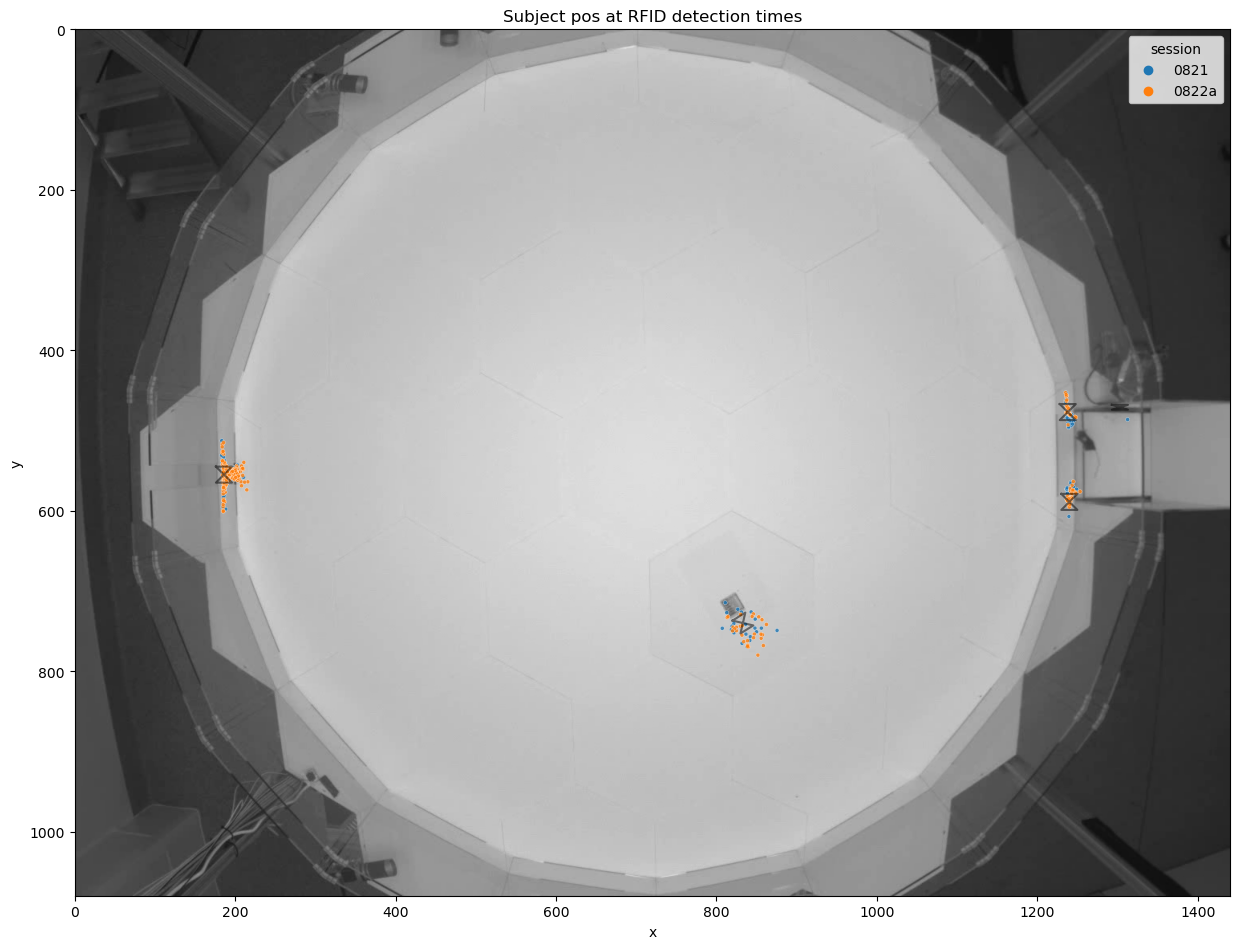

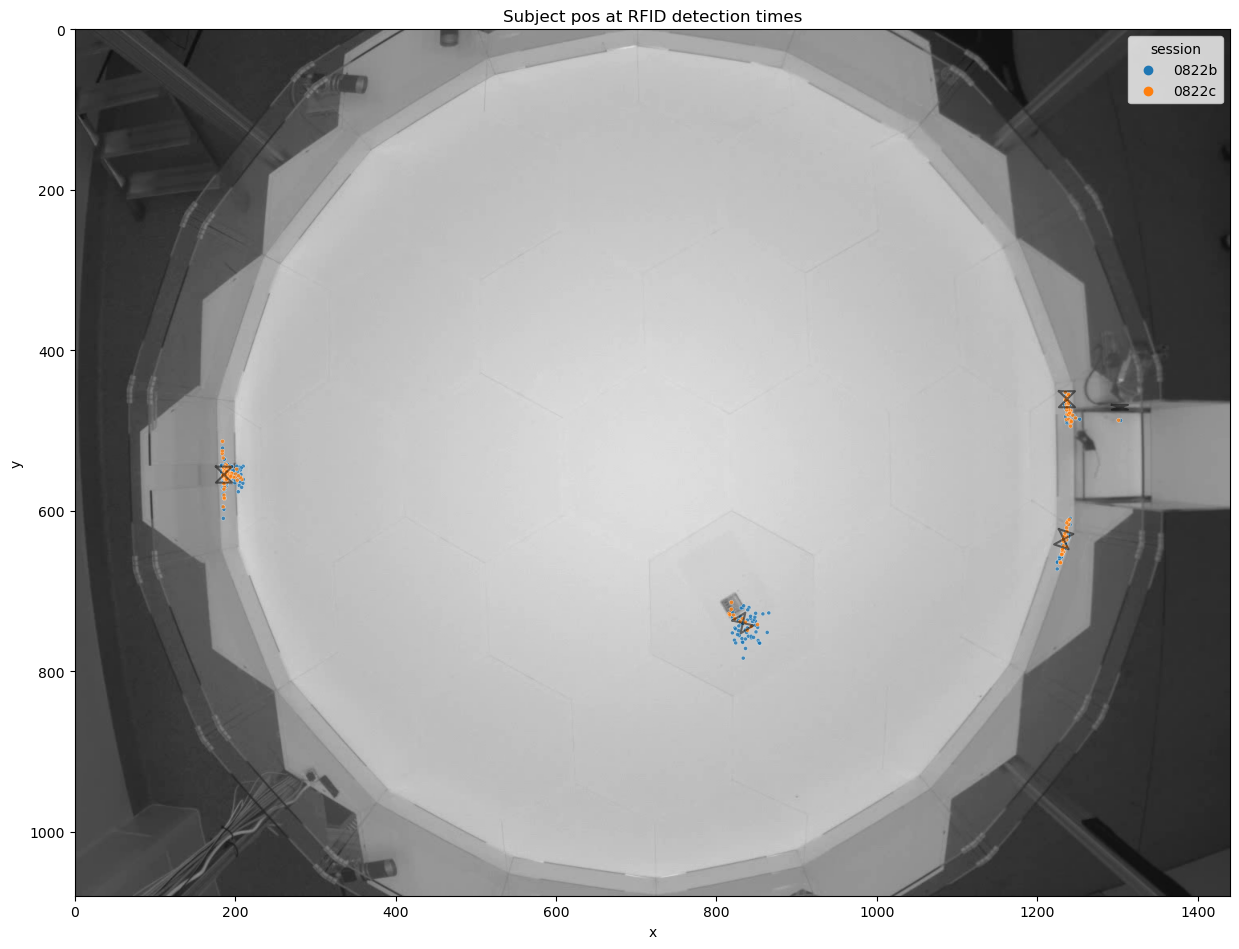

In [9]:
pos_enter_a = pd.concat([rfid_data["0821"]["pos_enter"].assign(session="0821"), rfid_data["0822a"]["pos_enter"].assign(session="0822a")])
pos_enter_b = pd.concat([rfid_data["0822b"]["pos_enter"].assign(session="0822b"), rfid_data["0822c"]["pos_enter"].assign(session="0822c")])

plot_pos_overlay(
    pos=pos_enter_a,
    img="aeon3_230821_rfidtest.png",
    title="Subject pos at RFID detection times",
    rfid_coords=rfid_coords_a,
    grouping_key="session",
)

plot_pos_overlay(
    pos=pos_enter_b,
    img="aeon3_230821_rfidtest.png",
    title="Subject pos at RFID detection times",
    rfid_coords=rfid_coords_b,
    grouping_key="session",
)

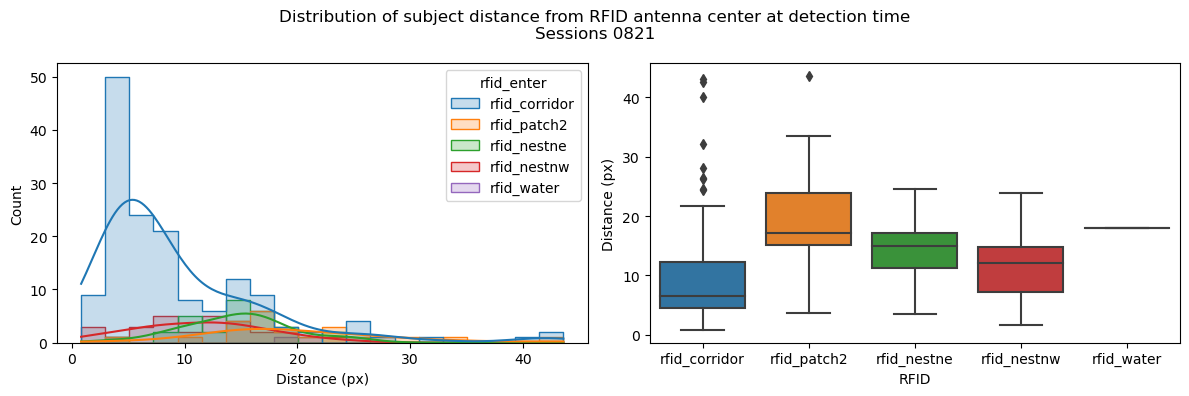

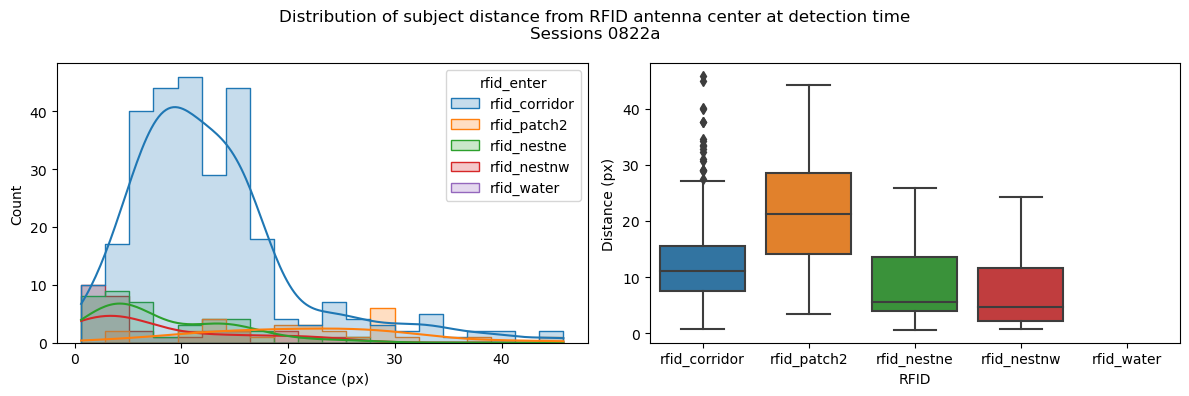

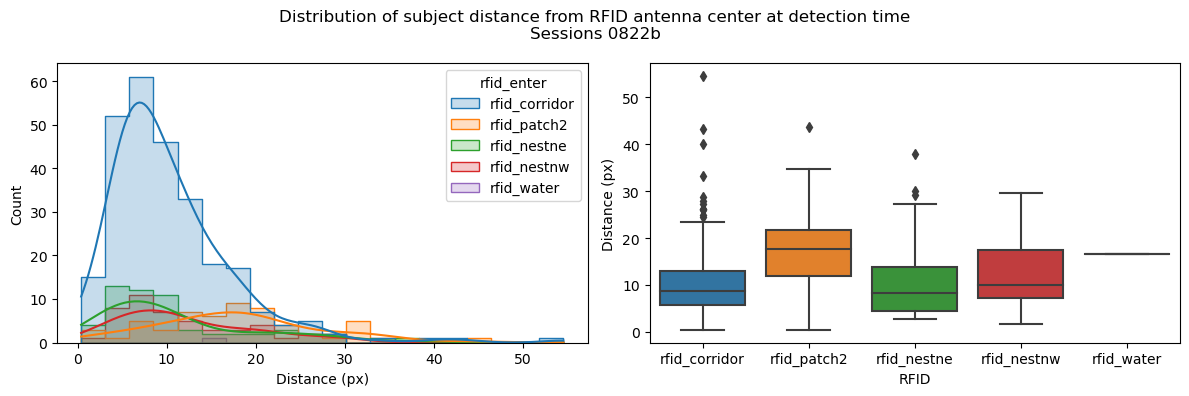

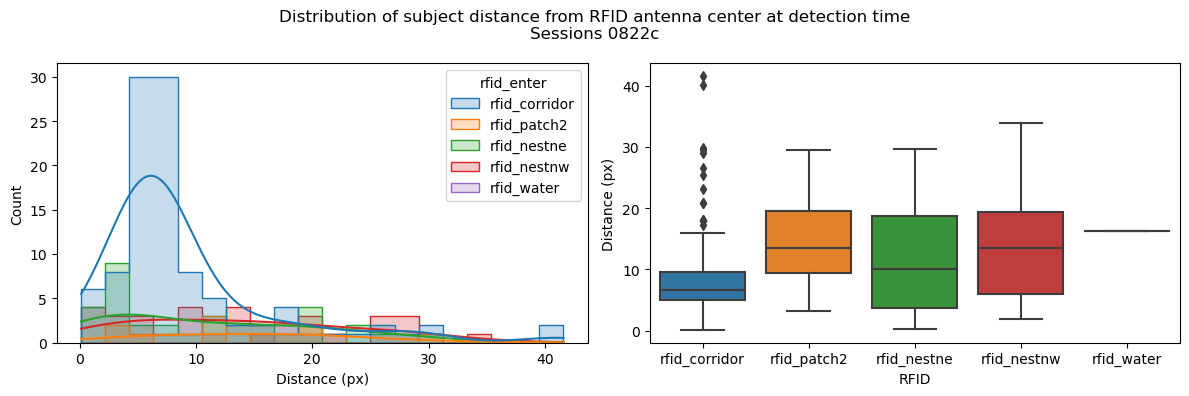

In [10]:
# Distribution of subject distance from RFID antenna center at detection time
for session in rfid_data.keys():
    plot_hist_boxplot(rfid_data[session]["pos_enter"], f"Session {session}", order=rfid_keys_a)

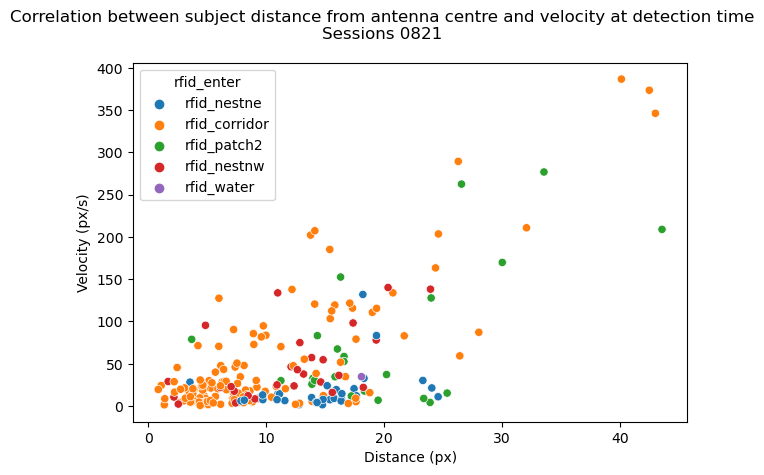

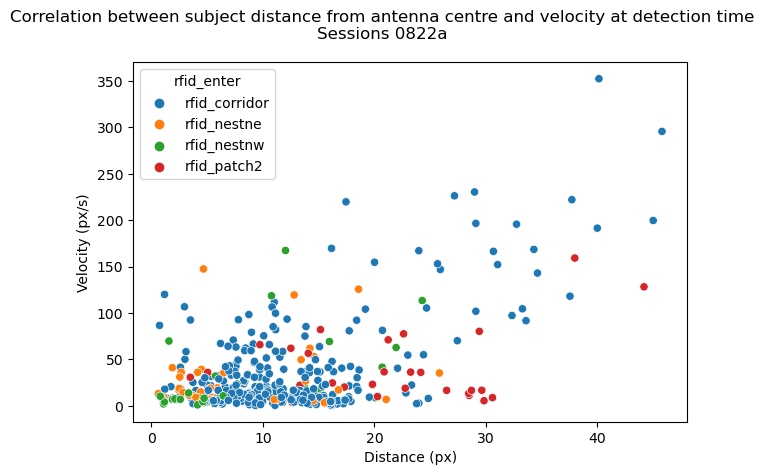

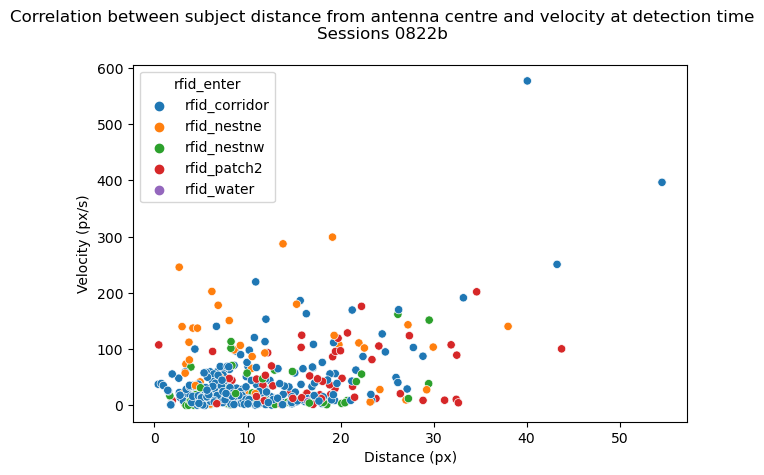

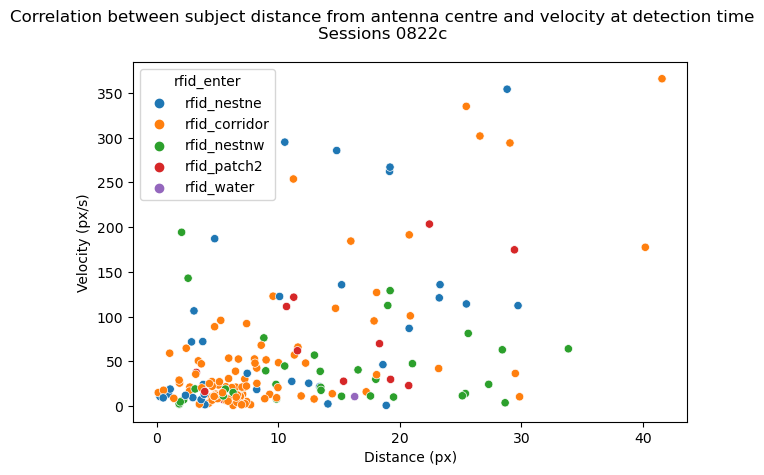

In [1226]:
# Correlation between subject distance from antenna centre and velocity at detection time
for session in rfid_data.keys():
    plot_correlation(rfid_data[session]["pos_enter"], f"Session {session}")

In [11]:
# compute correlation coefficient between distance and velocity for each RFID
for session in rfid_data.keys():
    print(f"Session {session}", rfid_data[session]["pos_enter"].groupby("rfid_enter")[["rfid_dist", "velocity"]].apply(lambda x: np.corrcoef(x["rfid_dist"], x["velocity"])[0,1]))

Session 0821 rfid_enter
rfid_corridor    0.799175
rfid_nestne      0.282855
rfid_nestnw      0.569059
rfid_patch2      0.594124
rfid_water            NaN
dtype: float64
Session 0822a rfid_enter
rfid_corridor    0.612568
rfid_nestne      0.197663
rfid_nestnw      0.528899
rfid_patch2      0.275603
dtype: float64
Session 0822b rfid_enter
rfid_corridor    0.576348
rfid_nestne      0.159616
rfid_nestnw      0.324044
rfid_patch2      0.287085
rfid_water            NaN
dtype: float64
Session 0822c rfid_enter
rfid_corridor    0.685224
rfid_nestne      0.528339
rfid_nestnw      0.014193
rfid_patch2      0.572937
rfid_water            NaN
dtype: float64


In [13]:
# compute time delta between successive triggers
rfid_time_delta = pd.DataFrame()
rfid_time_delta = pd.concat([pd.concat([rfid_data[session][key]["enter"].index.to_series().diff().dt.total_seconds() for key in rfid_keys_a], axis=1) for session in rfid_data.keys()])
rfid_time_delta.columns = rfid_keys_a
rfid_time_delta.describe()

,rfid_corridor,rfid_patch2,rfid_nestne,rfid_nestnw,rfid_water
count,809.000000,116.000000,158.000000,137.000000,1.000000
mean,11.590215,72.224458,58.121989,58.725309,0.398336
std,25.658460,160.340716,119.340536,96.258103,NaN
min,0.122624,0.091968,0.153216,0.153280,0.398336
25%,0.383744,0.398520,0.398368,0.429376,0.398336
50%,0.460416,0.587424,5.346048,4.724512,0.398336
75%,10.647616,39.377088,79.688456,79.793920,0.398336
max,241.260800,1076.370400,975.618912,435.624320,0.398336


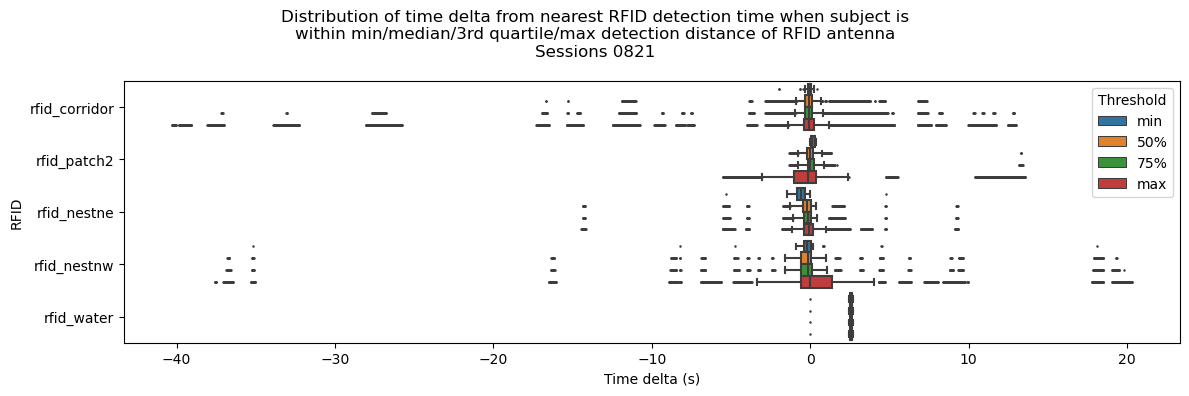

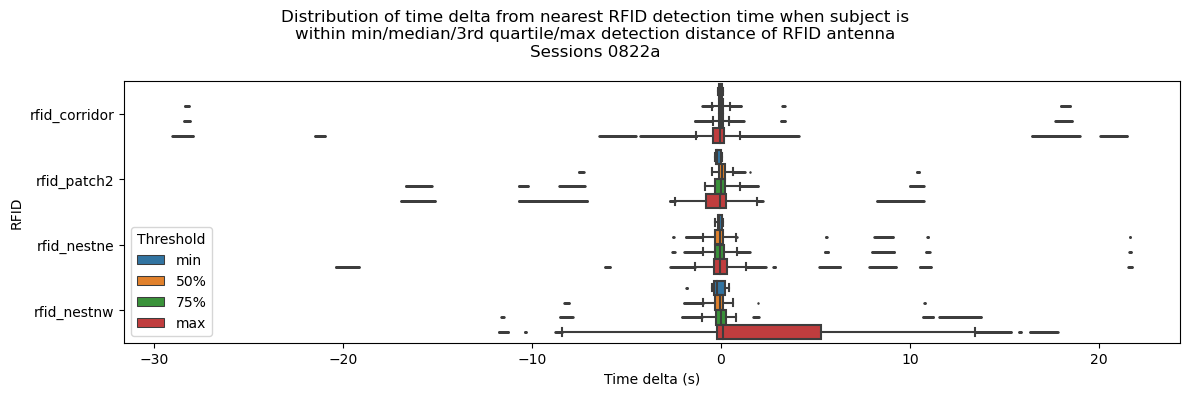

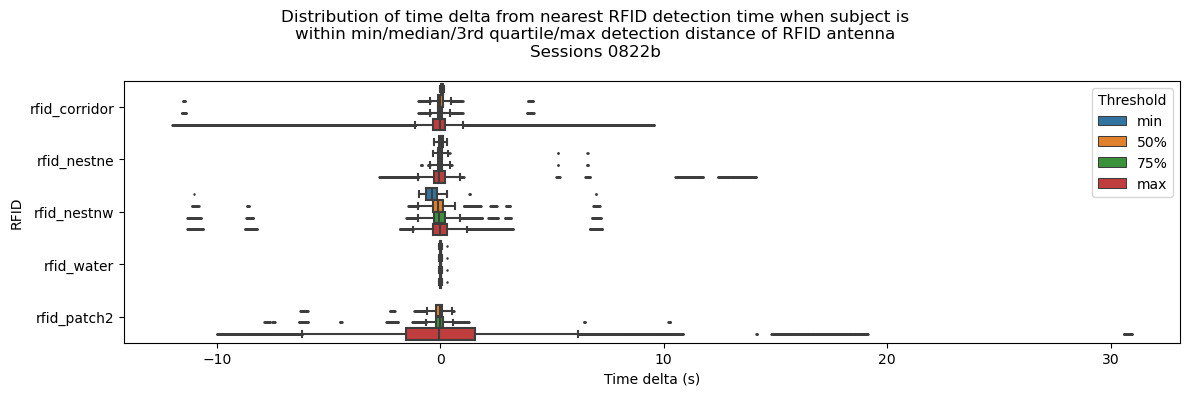

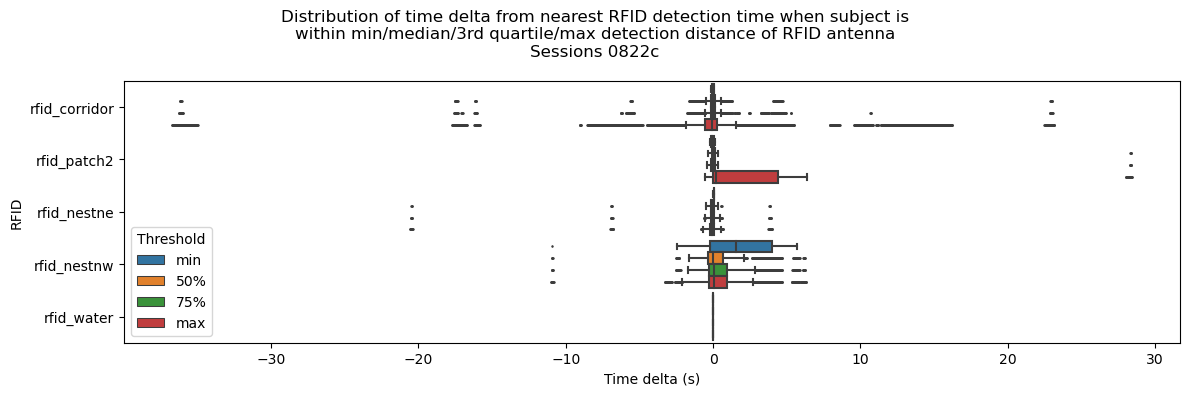

In [14]:
for session in rfid_data.keys():
    plot_multiple_thresholds(rfid_data[session]["pos_near_rfid"], f"Session {session}")

#### False negatives as subject within detection distance threshold but no RFID reads within a time window
For each RFID antenna:
- Pos threshold = 3rd quartile of subject distance from RFID center at detection time 
- Timedelta thresholds = For all the times when subject pos is within Pos threshold, (Q1-1.5*IQR, Q3+1.5*IQR) of timedelta from the nearest RFID detection time
- **FALSE NEGATIVES** = (subject position is within pos threshold) AND (there are no RFID reads within timedelta thresholds)

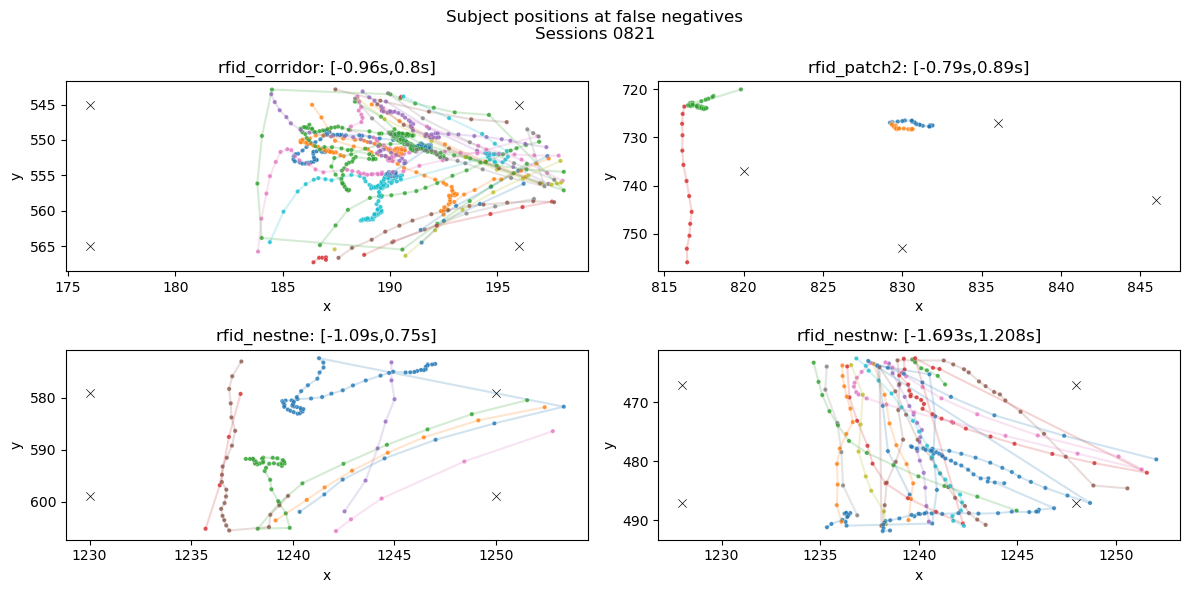

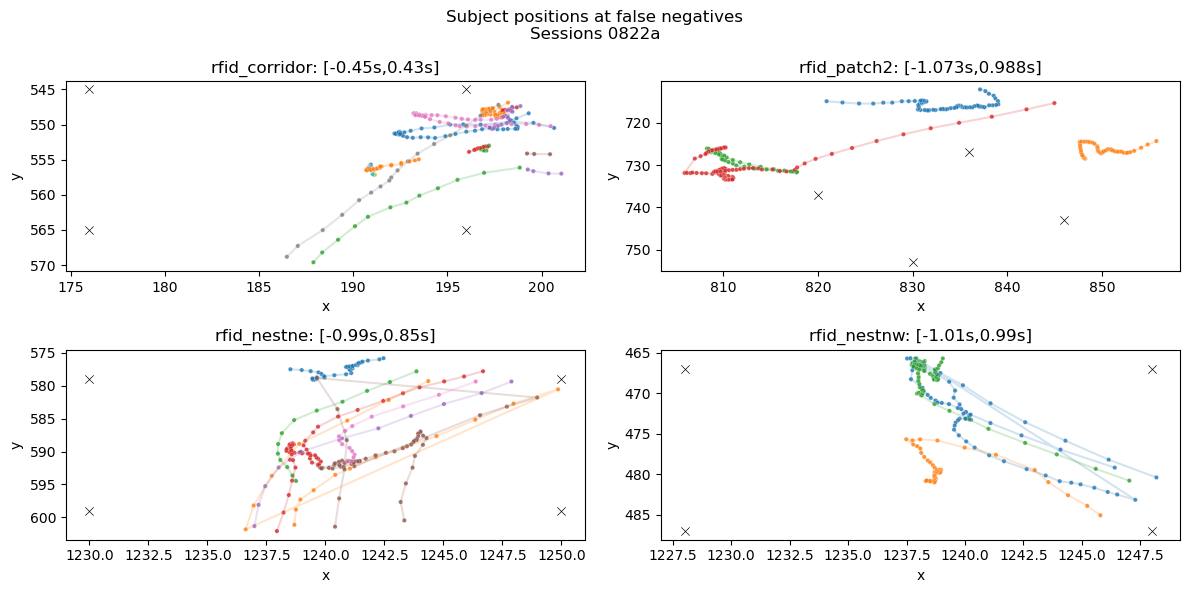

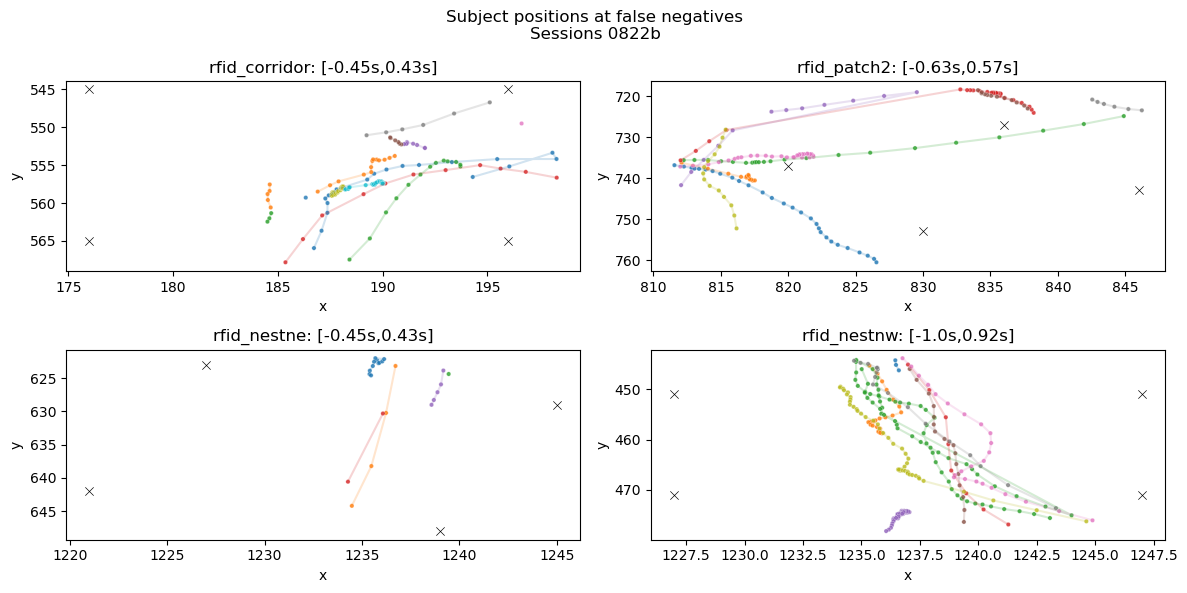

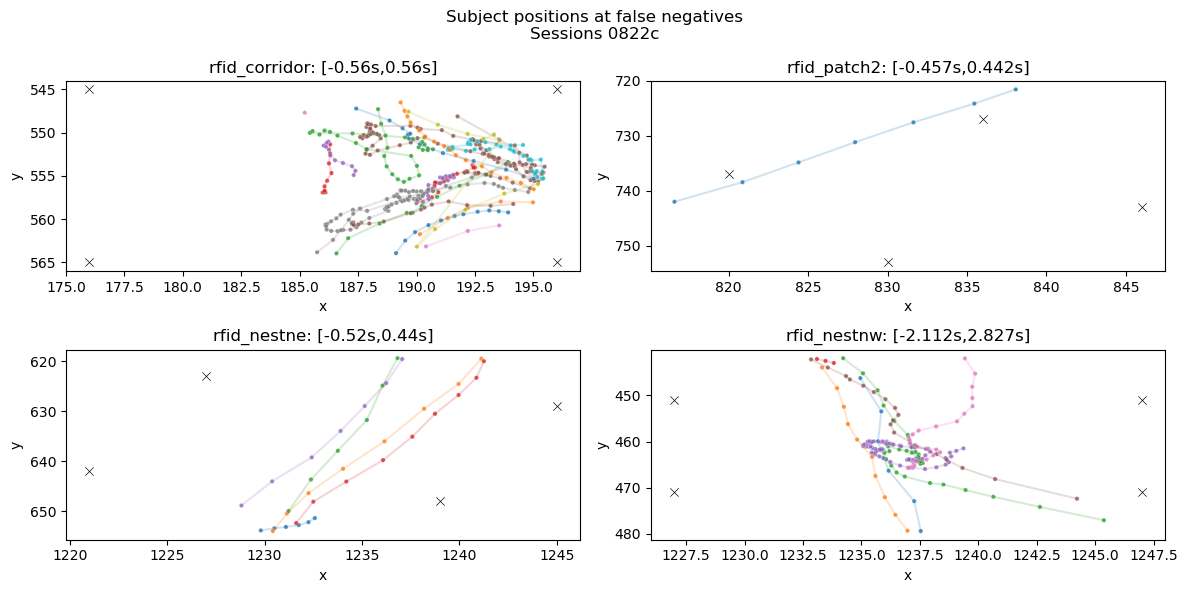

In [18]:
for session in rfid_data.keys():
    plot_fn_paths(
        rfid_data[session]["pos_near_rfid_q3_fn"], 
        rfid_data[session]["timedelta_thresholds"], 
        rfid_keys_a, 
        [rfid_data[session][key]["coords"] for key in rfid_keys_a],
        f"Session {session}"
    )

In [19]:
# percentage of false negatives within 75% distance threshold
for session in rfid_data.keys():
    print(f"Session {session}", rfid_data[session]["pos_near_rfid_q3_fn"].groupby("rfid_enter").size() / rfid_data[session]["pos_near_rfid_q3"].groupby("rfid_enter").size())

Session 0821 rfid_enter
rfid_corridor    0.205476
rfid_nestne      0.162791
rfid_nestnw      0.245387
rfid_patch2      0.137980
rfid_water       0.076923
dtype: float64
Session 0822a rfid_enter
rfid_corridor    0.055601
rfid_nestne      0.164297
rfid_nestnw      0.246548
rfid_patch2      0.265263
dtype: float64
Session 0822b rfid_enter
rfid_corridor    0.033988
rfid_nestne      0.026018
rfid_nestnw      0.168212
rfid_patch2      0.158033
rfid_water       0.166667
dtype: float64
Session 0822c rfid_enter
rfid_corridor    0.183092
rfid_nestne      0.052786
rfid_nestnw      0.133663
rfid_patch2      0.035000
rfid_water            NaN
dtype: float64


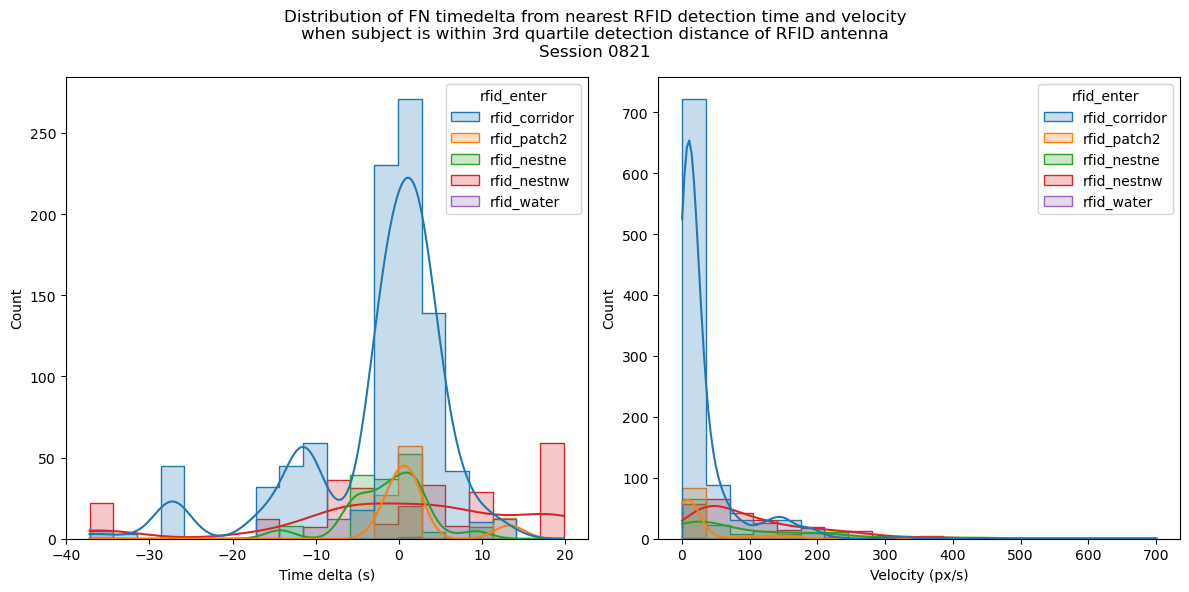

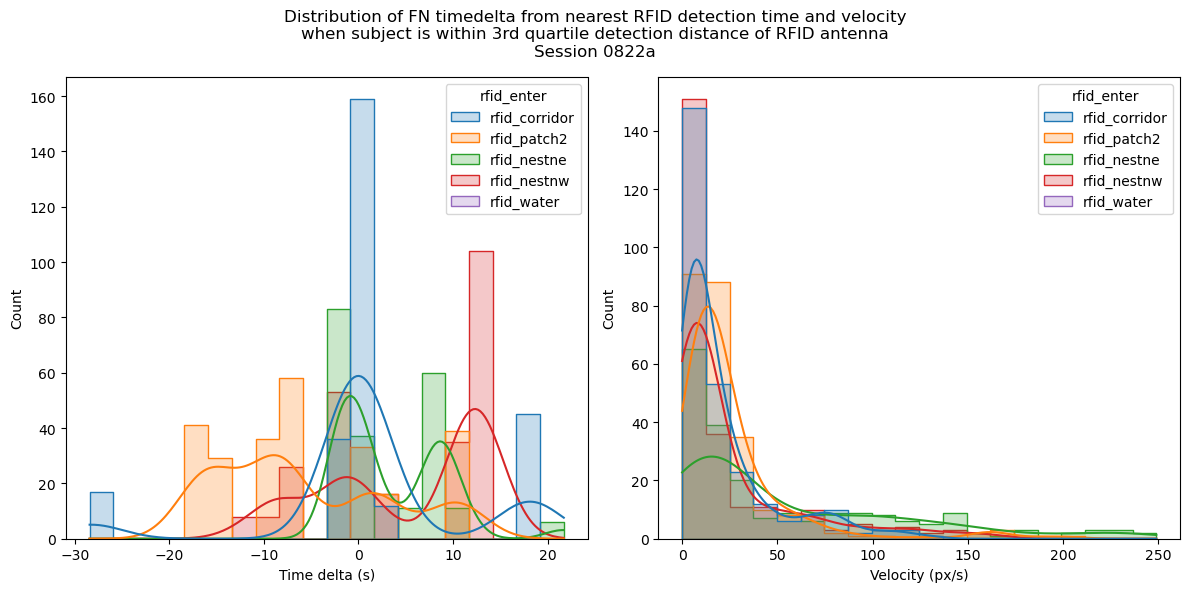

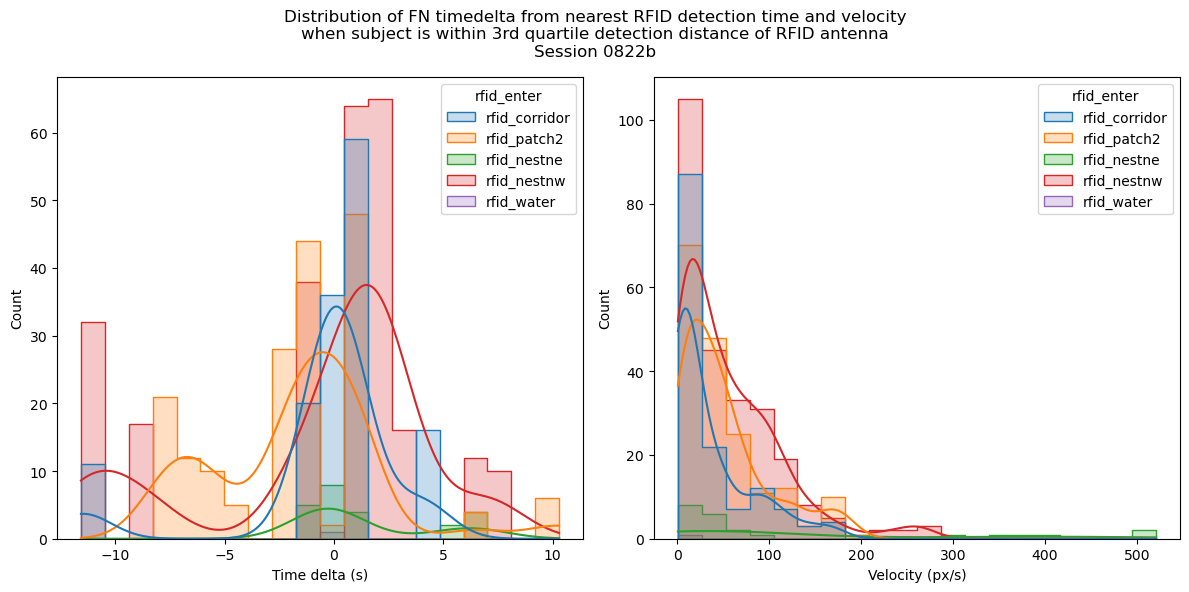

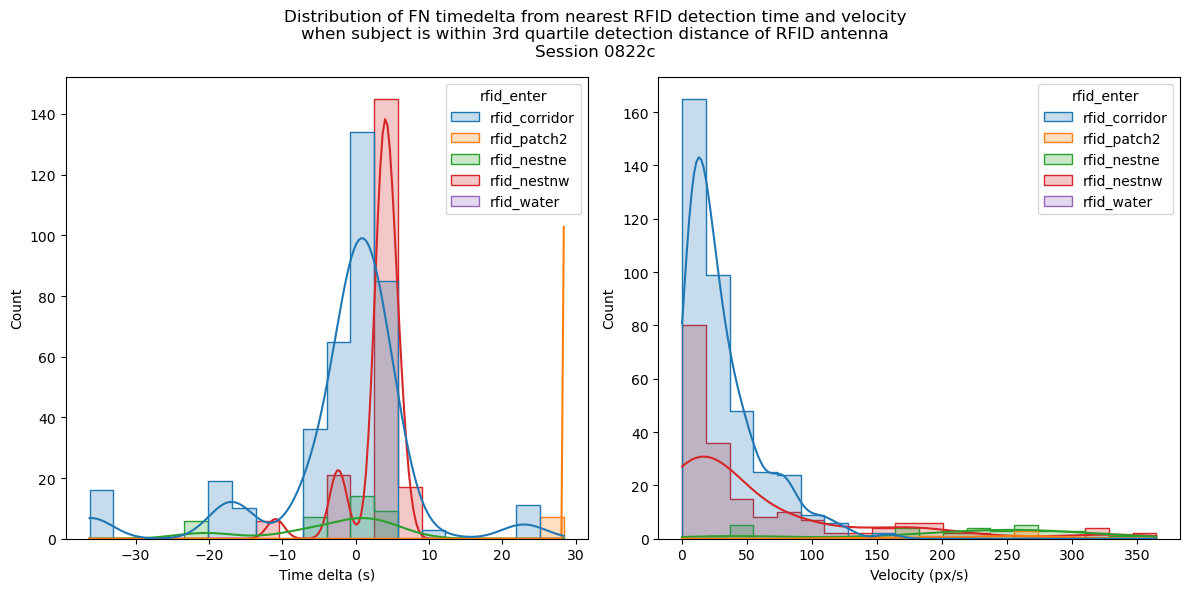

In [1282]:
for session in rfid_data.keys():
    plot_fn_timedelta_distributions(rfid_data[session]["pos_near_rfid_q3_fn"], f"Session {session}", order=rfid_keys_a)

#### False negatives by calculating number of RFID reads during ROI visits
For each RFID antenna:
- Pos threshold = 3rd quartile of subject distance from RFID center at detection time 
- ROI enter = time when subject pos first reaches pos threshold
- ROI exit = time when subject pos first exceeds pos threshold
- **FALSE NEGATIVES** = No RFID reads between ROI enter and ROI exit

In [50]:
# count percentage of 0 detection in all entries
for session in rfid_data.keys():
    print(f"Session {session}", rfid_data[session]["roi_enter_exit"].groupby("rfid_enter")["rfid_reads"].agg(lambda x: x.eq(0).sum()/len(x)))

Session 0821 rfid_enter
rfid_corridor    0.295238
rfid_nestne      0.320000
rfid_nestnw      0.511111
rfid_patch2      0.062500
rfid_water       1.000000
Name: rfid_reads, dtype: float64
Session 0822a rfid_enter
rfid_corridor    0.089109
rfid_nestne      0.148148
rfid_nestnw      0.266667
rfid_patch2      0.166667
Name: rfid_reads, dtype: float64
Session 0822b rfid_enter
rfid_corridor    0.032967
rfid_nestne      0.081081
rfid_nestnw      0.290323
rfid_patch2      0.129032
rfid_water       0.500000
Name: rfid_reads, dtype: float64
Session 0822c rfid_enter
rfid_corridor    0.272727
rfid_nestne      0.160000
rfid_nestnw      0.303030
rfid_patch2      0.200000
Name: rfid_reads, dtype: float64


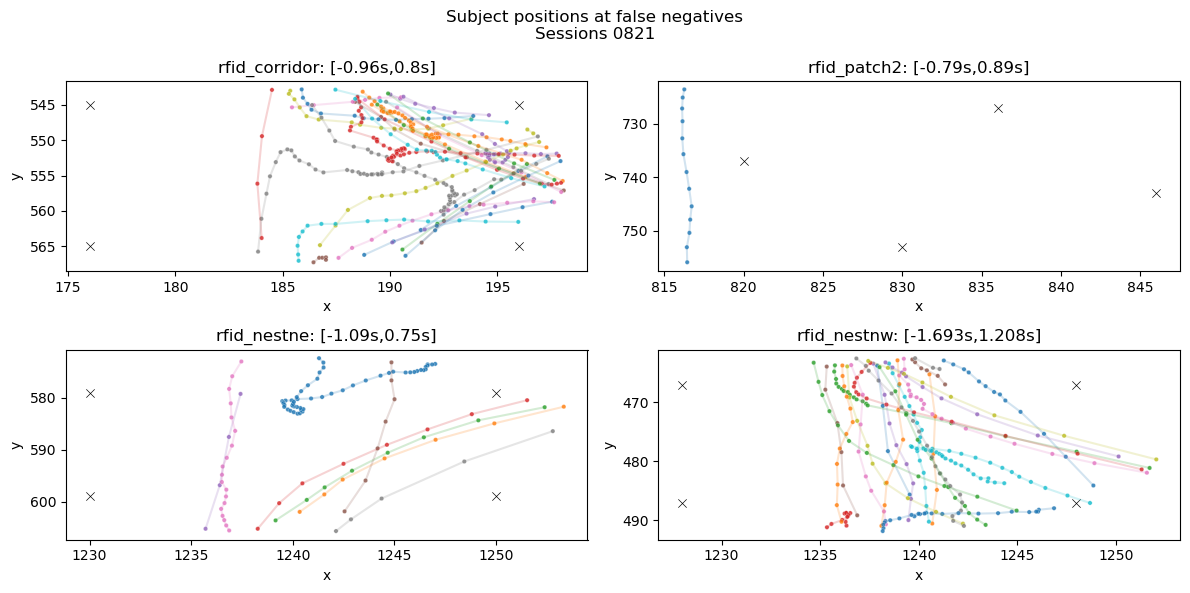

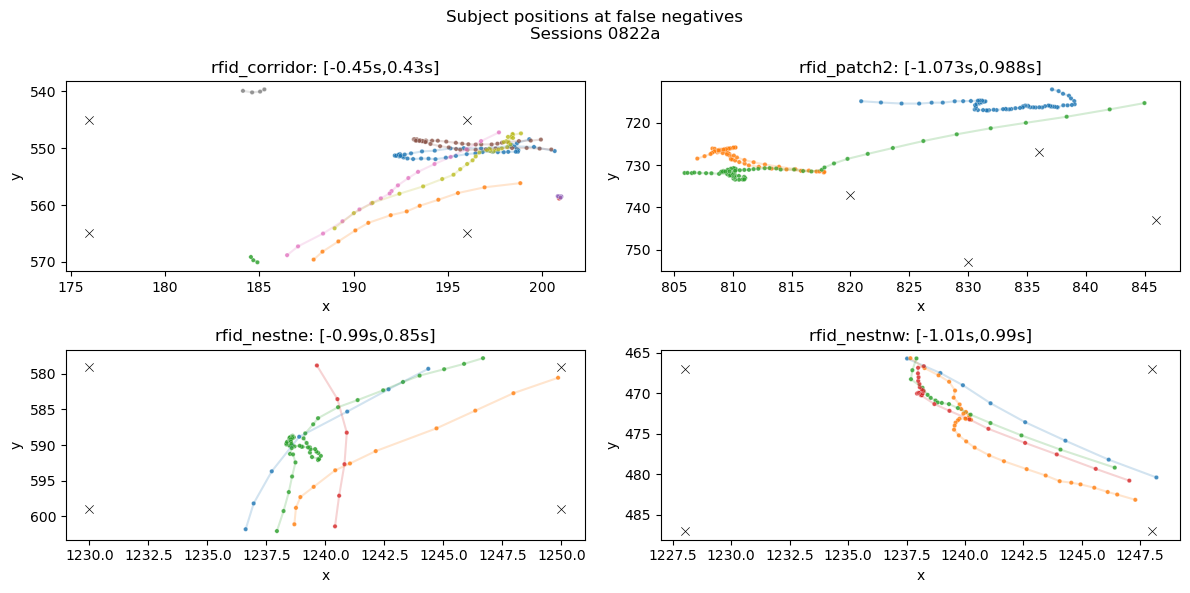

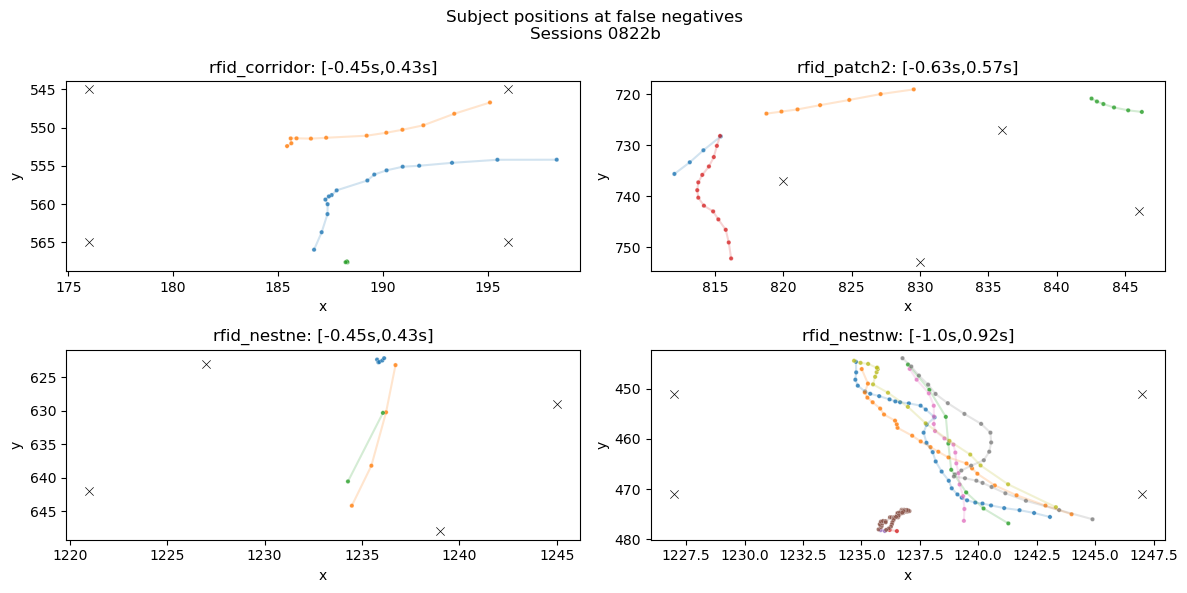

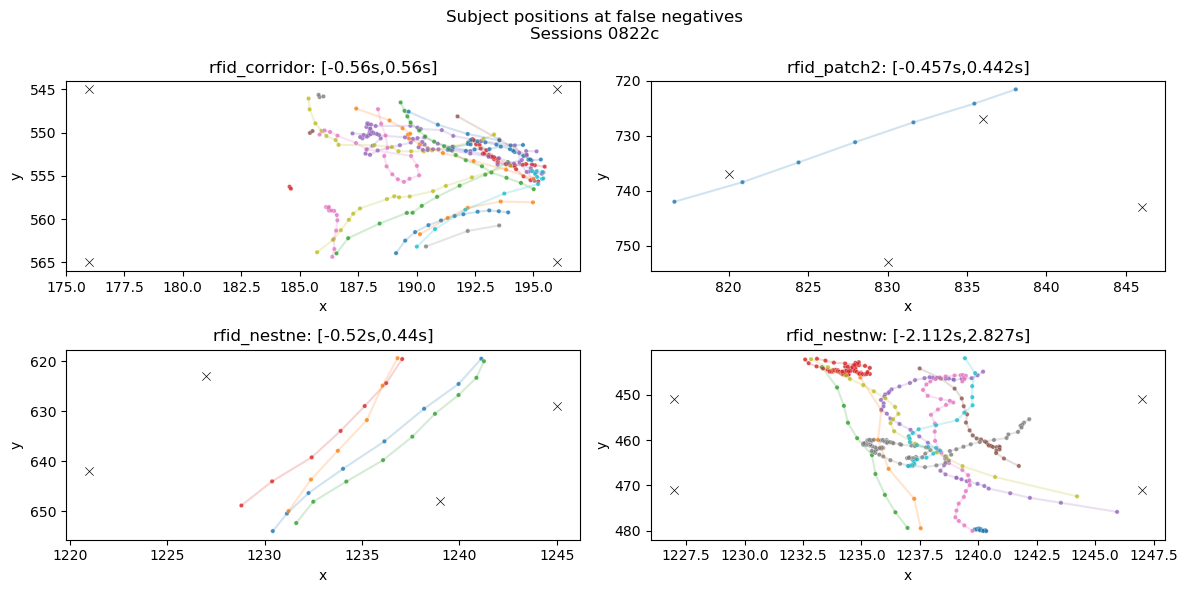

In [1296]:
for session in rfid_data.keys():
    plot_fn_paths(rfid_data[session]["roi_enter_exit_fn_paths"], rfid_data[session]["timedelta_thresholds"], rfid_keys_a, [rfid_data[session][key]["coords"] for key in rfid_keys_a], f"Session {session}", grouping_key="group")
#plot_fn_paths(roi_enter_exit_fn_paths, timedelta_thresholds, rfid_keys, rfid_coords, "Session 0822b", grouping_key="group")

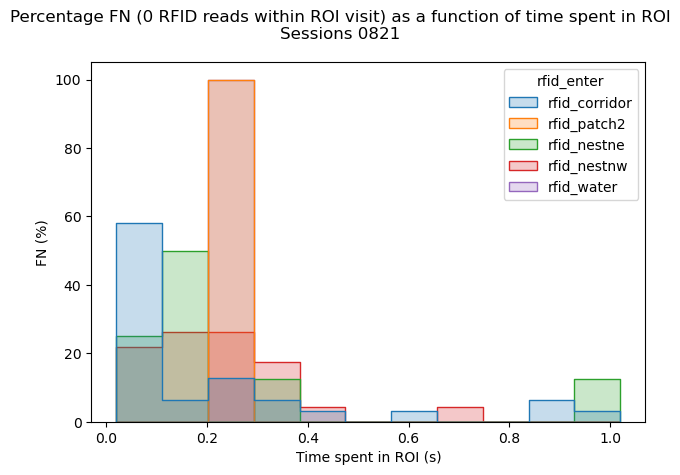

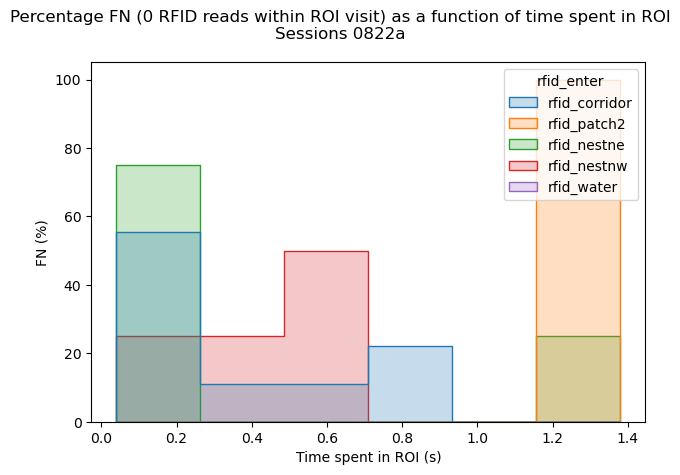

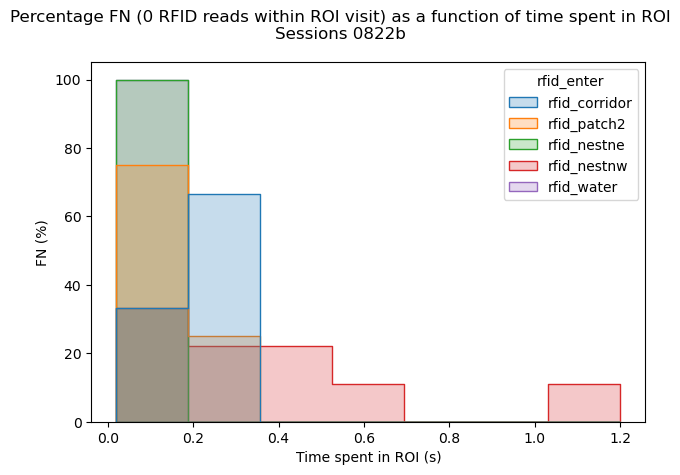

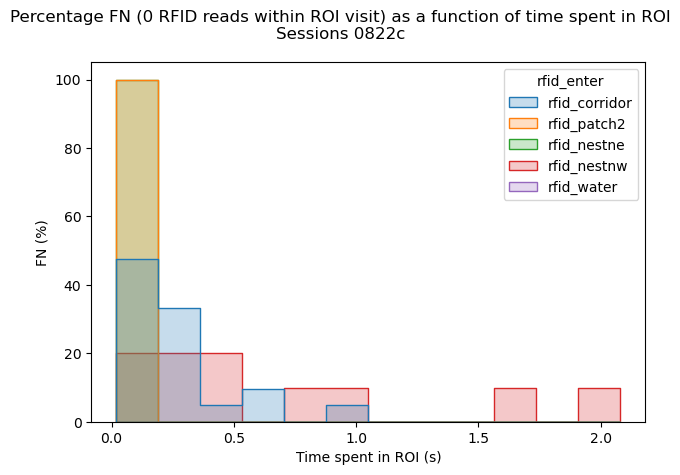

In [10]:
# plot number of fn as a function of time spent in roi
for session in rfid_data.keys():
    roi_enter_exit = rfid_data[session]["roi_enter_exit"]
    fig, ax = plt.subplots()
    sns.histplot(roi_enter_exit[roi_enter_exit["rfid_reads"] < 1], x="dt", hue="rfid_enter", hue_order=rfid_keys_a, stat="percent", element="step", common_norm=False, ax=ax)
    ax.set_xlabel("Time spent in ROI (s)")
    ax.set_ylabel("FN (%)")
    plt.suptitle(f"Percentage FN (0 RFID reads within ROI visit) as a function of time spent in ROI\nSessions {session}")
    plt.tight_layout()



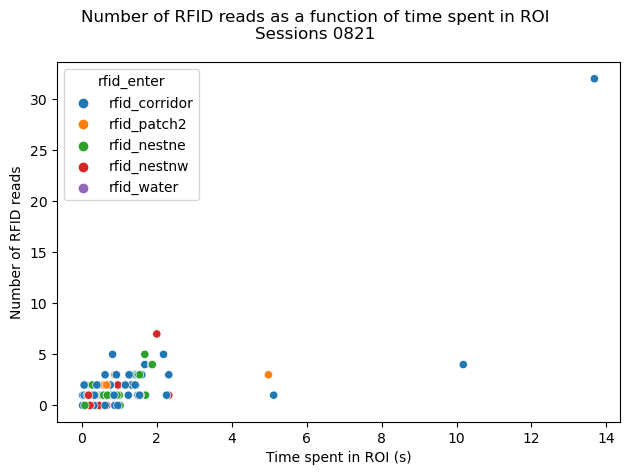

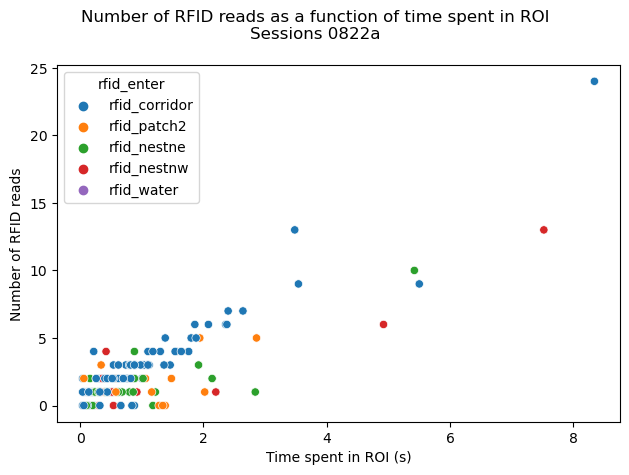

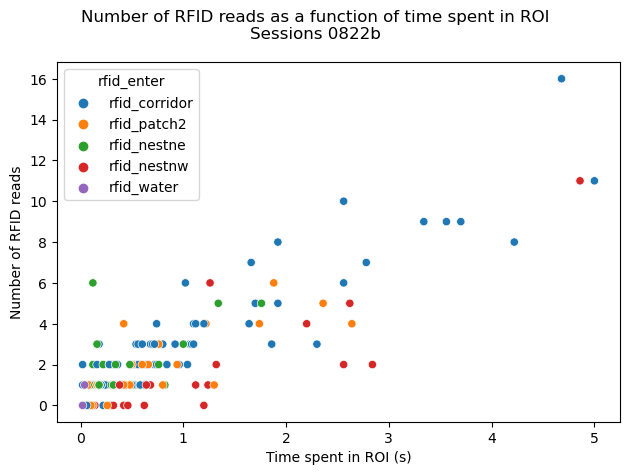

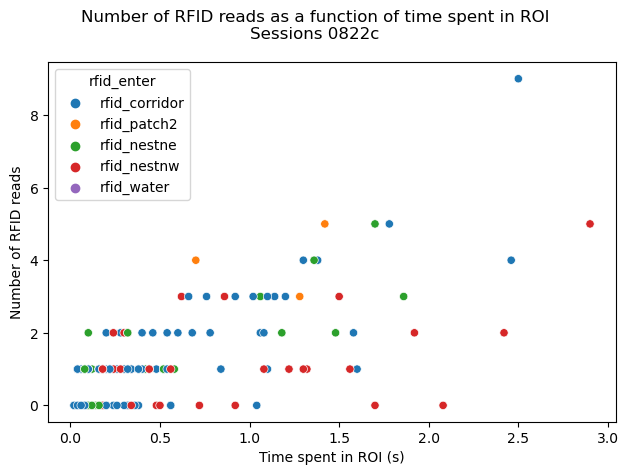

In [11]:
# plot number of rfid reads as a function of time spent in roi
for session in rfid_data.keys():
    roi_enter_exit = rfid_data[session]["roi_enter_exit"]
    fig, ax = plt.subplots()
    sns.scatterplot(data=roi_enter_exit, x="dt", y="rfid_reads", hue="rfid_enter", hue_order=rfid_keys_a, ax=ax)
    ax.set_xlabel("Time spent in ROI (s)")
    ax.set_ylabel("Number of RFID reads")
    plt.suptitle(f"Number of RFID reads as a function of time spent in ROI\nSessions {session}")
    plt.tight_layout()
